##### Proyecto Final BEDU Python (3 y 4)
### Clasificador de Imágenes de RMN usando una  red neuronal convolucionada prediseñada y su comparación con métodos de aprendizaje supervisado (KNN y SVM).

`03/2021 - 07/2021`

> García Espinosa David Alexis 

> Este proyecto está inspirado en el curso `AI for Medical Diagnosis` disponible en [Coursera](https://www.coursera.org/learn/ai-for-medical-diagnosis)

#### Motivación:

El propósito de este trabajo es generar una herramienta novedosa para la clasificación de imágenes de resonancia magnñetica nuclear, usualmente tomandas/generadas en hospitales de alta necesidad.

#### Base de Datos utilizada:

La base de datos utilizada es una colección de imágenes apartada de la base general llamada `BraTS` de la competenciua realizada desde _2012_ _Brain Tumor Segmentation Challenge_ y puede ser consultada desde [Kaggle](https://www.kaggle.com/jakeshbohaju/brain-tumor) o si se desea la base completa y sus [especificaciones ](https://www.smir.ch/BRATS/Start2015)

### Exploración

In [1]:
# Visualzación de imágenes extrenas.
from PIL import Image
from PIL.ExifTags import TAGS

# Bibliotecas a utilizar.
import pandas as pd
import numpy as np 
import seaborn as sns
import os 
import matplotlib.pyplot as plt

In [2]:
# Lectura del .csv
dfmr = pd.read_csv('Brain Tumor.csv')
# Primera vista a la base de datos.
dfmr.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [3]:
#Notamos la cantidad de información que podemos obtener a partir del preprocesamiento de las imágenes, a estos datos
# los denotaremos como atributos.
dfmr.columns

Index(['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation', 'Entropy',
       'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity',
       'Dissimilarity', 'Correlation', 'Coarseness'],
      dtype='object')

In [4]:
# Conocer la información que contienen
dfmr.info()
# Vemos que no continen valores nulos o NaN y por lo tanto podemos considerar que 
# la base de datos está "Limpia"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               3762 non-null   object 
 1   Class               3762 non-null   int64  
 2   Mean                3762 non-null   float64
 3   Variance            3762 non-null   float64
 4   Standard Deviation  3762 non-null   float64
 5   Entropy             3762 non-null   float64
 6   Skewness            3762 non-null   float64
 7   Kurtosis            3762 non-null   float64
 8   Contrast            3762 non-null   float64
 9   Energy              3762 non-null   float64
 10  ASM                 3762 non-null   float64
 11  Homogeneity         3762 non-null   float64
 12  Dissimilarity       3762 non-null   float64
 13  Correlation         3762 non-null   float64
 14  Coarseness          3762 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 441.0

In [5]:
# Conocer si la información dada es única para cada valor 
# o si existe dentro de la BD valores de pacientes repetidos.

# De manera similar a la sintaxis SQL hacemos un conteo en la columna 'PatientID'
# Columna que guarda las identificaciones por número de cada uno de los pacientes
print('Total de datos en Patient ID:',dfmr['Image'].count())

#De los cuales podemos obtener cuantos son únicos:
print('Total de Pacientes reales (únicos):',dfmr['Image'].value_counts().shape[0])

# Podemos suponer los datos a utilizar pertenecen a pacientes distintos (por ahora...)

# Conocemos también las llaves es decir cómo están organizadas las columnas
columns = dfmr.keys()
columns = list(columns)
print('---------------------Columnas-------------------')
print(columns)
# Esto se realiza para observar si existe un desbalance en la BD.

Total de datos en Patient ID: 3762
Total de Pacientes reales (únicos): 3762
---------------------Columnas-------------------
['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness']


>Parte del preprocesamiento de los datos consiste en la limpieza de los mismos para esto podemos retirar del .csv la información que no necesitamos y que es candidata a eliminarse, para este caso eliminamos el ID (indice de la imagen) para los casos de aprendizaje supervisado.



In [6]:
#columns.remove('Image')
print('----------Nuevas columnas--------------')
print('Nuveas columnas:',columns)

----------Nuevas columnas--------------
Nuveas columnas: ['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness']


In [7]:
# Conocimiento del muestreo
# Se debe utilizar un estilo diferente de Data Frame
# En este caso cada imagen contiene su información correspondiente
print('-----------Valores en 1---------------------------')
print(dfmr[dfmr['Class']==1].count())
print('-----------Valores en 0---------------------------')
print(dfmr[dfmr['Class']==0].count())

# Contenido poco desbalanceado 

-----------Valores en 1---------------------------
Image                 1683
Class                 1683
Mean                  1683
Variance              1683
Standard Deviation    1683
Entropy               1683
Skewness              1683
Kurtosis              1683
Contrast              1683
Energy                1683
ASM                   1683
Homogeneity           1683
Dissimilarity         1683
Correlation           1683
Coarseness            1683
dtype: int64
-----------Valores en 0---------------------------
Image                 2079
Class                 2079
Mean                  2079
Variance              2079
Standard Deviation    2079
Entropy               2079
Skewness              2079
Kurtosis              2079
Contrast              2079
Energy                2079
ASM                   2079
Homogeneity           2079
Dissimilarity         2079
Correlation           2079
Coarseness            2079
dtype: int64


In [8]:
# Renombrar la información de cada imagen para manipular desde la base de datos 

# Nombre de las imágenes (Falta la extensión .jpg)
nombre_list = dfmr['Image']
# Definimos la cadena que queremos agregar a cada nombre 
string = '.jpg'
# Suma de cadenas con un método de comprehension list
new_list = [x + string for x in nombre_list]
# Actualización en el Data Frame
dfmr['Image']=new_list
dfmr

# No correr muchas veces sólo una vez

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1.jpg,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2.jpg,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3.jpg,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4.jpg,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5.jpg,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Image3758.jpg,0,21.234512,1208.850174,34.768523,0.063774,2.082079,4.647310,158.437600,0.220666,0.048693,0.487131,5.211739,0.950972,7.458341e-155
3758,Image3759.jpg,0,20.435349,1227.151440,35.030721,0.066763,2.144625,4.882034,161.158675,0.225931,0.051045,0.502712,5.083126,0.952749,7.458341e-155
3759,Image3760.jpg,0,18.011520,1151.582765,33.934978,0.068396,2.308349,5.579498,167.130118,0.228930,0.052409,0.492269,5.103700,0.952181,7.458341e-155
3760,Image3761.jpg,0,13.330429,945.732779,30.752769,0.087872,2.732822,7.757570,223.812932,0.261527,0.068397,0.480064,6.439784,0.940898,7.458341e-155


In [9]:
# Probando como está estructurada la información en general para una imagen
imagen_prueba = dfmr.loc[np.random.choice(3762)]
imagen_prueba

Image                 Image1680.jpg
Class                             0
Mean                      16.891113
Variance                1044.809892
Standard Deviation        32.323519
Entropy                    0.078439
Skewness                   2.407744
Kurtosis                   6.226605
Contrast                 143.684832
Energy                     0.246117
ASM                        0.060574
Homogeneity                0.564028
Dissimilarity              3.816962
Correlation                0.958617
Coarseness                      0.0
Name: 1679, dtype: object

### Visualización General

Visualización de algunas imágenes


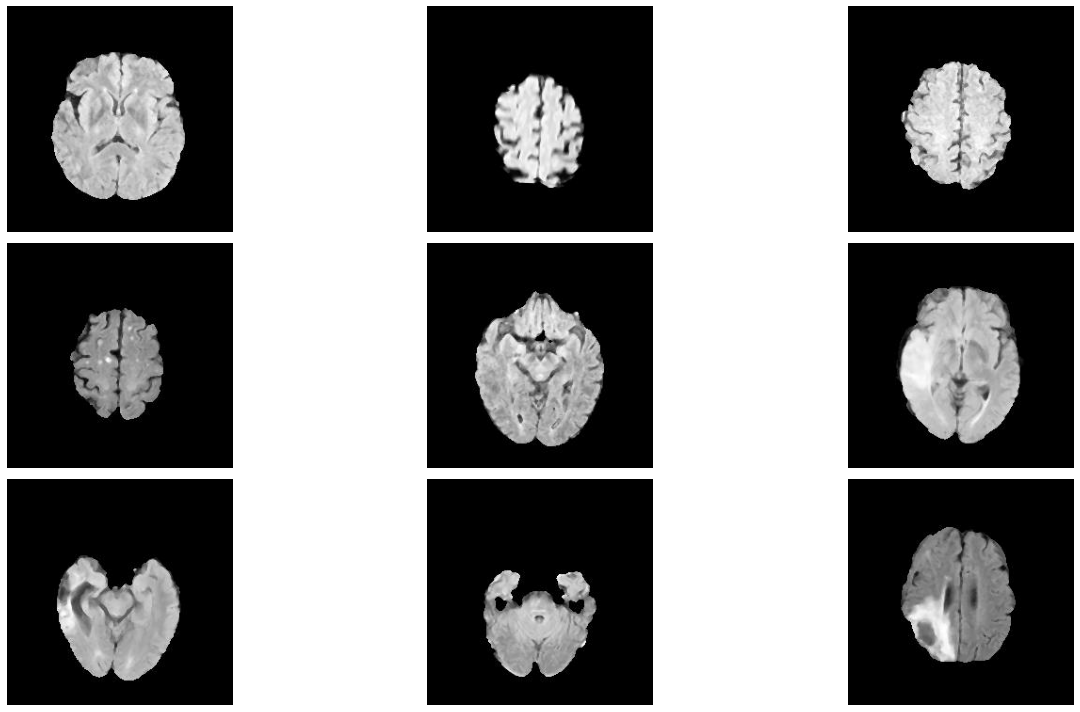

In [10]:
# Visualización (Fines didácticos) Base de datos con la que trabajaremos.

imagenes = dfmr['Image'].values
# Visualización de imágenes randomizado (9)
random_img = [np.random.choice(imagenes) for i in range(9)]
#/Users/davidg/Desktop/Temas Instrumentación/Pruebas PROYECTO f INSTRU/Brain Tumor/Brain Tumor
#Localización de las imágenes en el directorio (Cambiar de acuerdo al usuario)
#img_dir = '//Users/davidg/Desktop/archive/Brain Tumor/Brain Tumor/Image1.jpghome/ironsss/Downloads/septimo/Instrumentación/Proyecto_Final/archive/Brain Tumor/Brain Tumor'
img_dir = '/Users/davidg/Documents/GitHub/Proyecto-Final-BEDU/Brain Tumor/Brain Tumor/'
print('Visualización de algunas imágenes')
# Ajuste del tamaño
plt.figure(figsize=(20,10))
# Iteración para las imágenes

for i in range(9):
    plt.subplot(3, 3, i + 1) # Arreglo para la orgaización de las imágenes
    img = plt.imread(os.path.join(img_dir, random_img[i])) #Ploteo de acuerdo al directorio
    plt.imshow(img, cmap='gray') 
    plt.axis('off')
    
plt.tight_layout()   

### Análisis más profundo en imágenes

Las dimensiones de la imagen son (240x240), un solo color de canal
El valor máximo del pixel es 255.0000 y el valor mínimo es de 0.0000
El valor promedio de los pixeles es 40.2693 y su desviación estándar es 74.5256


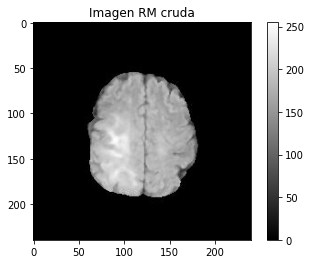

In [11]:
#np.random.seed(123) # Fijamos semilla
sample_img = dfmr.Image[np.random.choice(len(dfmr['Image']))]  # Cambiar valor para cualquier imagen
raw_image = plt.imread(os.path.join(img_dir, sample_img)) # lectura de directorio por nombre
plt.imshow(raw_image, cmap='gray') #impresión
plt.colorbar() # agregar escala de color
plt.title('Imagen RM cruda')
print(f"Las dimensiones de la imagen son ({raw_image.shape[0]}x{raw_image.shape[1]}), un solo color de canal")
print(f"El valor máximo del pixel es {raw_image.max():.4f} y el valor mínimo es de {raw_image.min():.4f}")
print(f"El valor promedio de los pixeles es {raw_image.mean():.4f} y su desviación estándar es {raw_image.std():.4f}")

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 150.0)

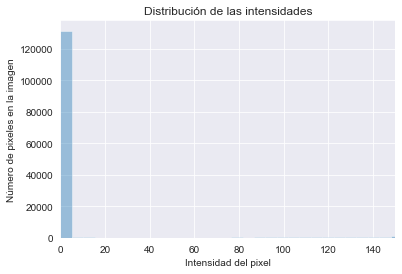

In [12]:
# Graficar histograma de la distribución de los pixeles
sns.set_style('darkgrid')
sns.distplot(raw_image.ravel(), kde = False)
plt.title('Distribución de las intensidades')
plt.xlabel('Intensidad del pixel')
plt.ylabel('Número de pixeles en la imagen')
plt.xlim(0,150)
#Observamos que los píxeles que predominan son de color negro - 0 como se esperaba.

### Estandarización y Normalización de la información


In [13]:
# Empezamos a utilizar paqueterñias de ML como Keras y sus funciones 
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [14]:
# Normalización
image_generator = ImageDataGenerator(
    samplewise_center=True, #Fija cada muestra a un promedio 0
    samplewise_std_normalization= True # Divide cada entrada por su desviación estándar
)


La estructura `image_generator` creada en el bloque superior permite que la información de las imagenes tengan un promedio fijado a 0 y una desviación estándar de 1.

Es decir el proceso de estandarización consiste en suistraer el promedio de los datos a cada uno de los datos y posteriormente dividir por su desviación estándar, este es un proceso común en métodos estadísticos.

$$X_n = \frac{x_i - \mu}{\sigma}$$

> Es importante mencionar que en este proceso el peso de la imagen se reduce a **320x320** píxeles.

In [15]:
generator = image_generator.flow_from_dataframe( # función usada anteriormente pero aplicada a todo el dataset 
        dataframe= dfmr,   # dataset que utilizamos
        directory=img_dir, # directorio de las imágenes
        x_col="Image", # características es decir a quíen va dirijido el proceso 
        y_col= ['Class'], # atributos
        class_mode="raw", # La columna'Class' deberá estar presente en el entrenamiento pero no en el test.
        batch_size= 1, # imagenes por batch 
        shuffle=False, # mezclar las columnas o no (proceso de alateoridad de la muestra)
        target_size=(320,320) # tamaño final de la muestra
)

Found 3762 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Dimensiones (320x320)
Promedio:3.3883 Minimo:-0.5471
Valor promedio generado:-0.0000 desviación estándar1.0000


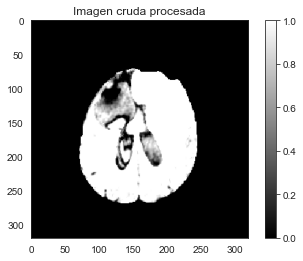

In [16]:
# Muestra de una imagen posterior al preprocesamiento.
sns.set_style("white")
generated_image, label = generator.__getitem__(np.random.choice(3762))
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Imagen cruda procesada')
print(f"Dimensiones ({generated_image.shape[1]}x{generated_image.shape[2]})")
print(f"Promedio:{generated_image.max():.4f} Minimo:{generated_image.min():.4f}")
print(f"Valor promedio generado:{generated_image.mean():.4f} desviación estándar{generated_image.std():.4f}")

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


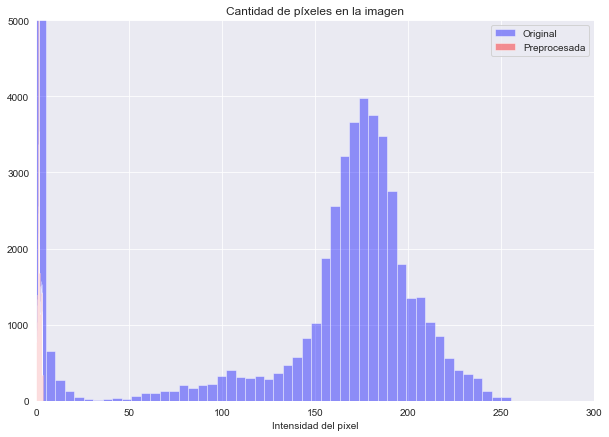

In [17]:
# Comparación de la distribuxión de píxeles.
sns.set_style('darkgrid')
plt.figure(figsize=(10, 7))
plt.ylim(0,5000)
plt.xlim(0,300)
# Histograma de la imagen original
sns.distplot(raw_image.ravel(),label='Original',color='blue',kde=False)
# Histograma de la imagen preprocesada
sns.distplot(generated_image[0].ravel(),label='Preprocesada',color='red',kde=False)
# Place legendS
plt.title('Cantidad de píxeles en la imagen')
plt.xlabel('Intensidad del píxel')
plt.legend()
plt.show()

### Distribución de atributos

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


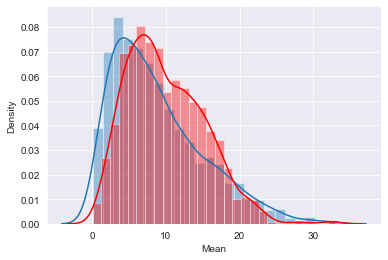

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


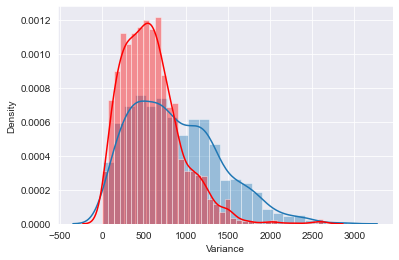

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


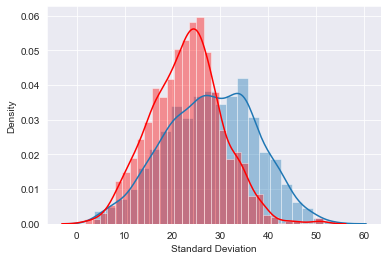

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


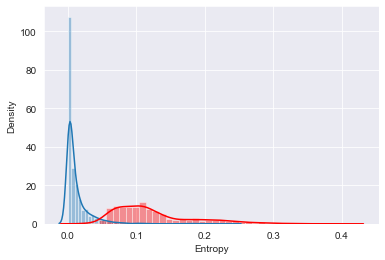

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


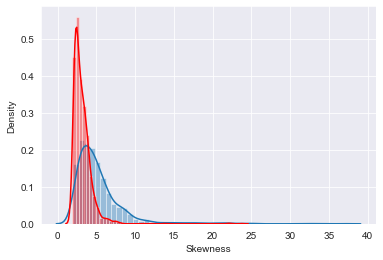

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


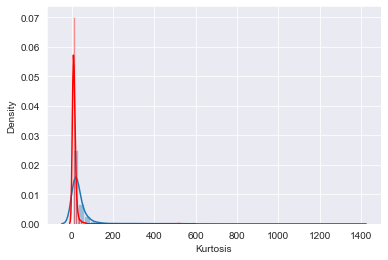

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


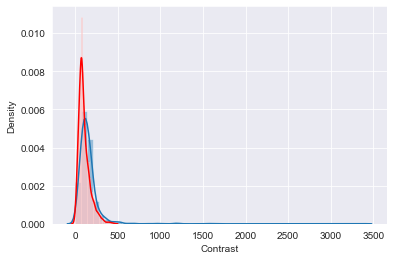

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


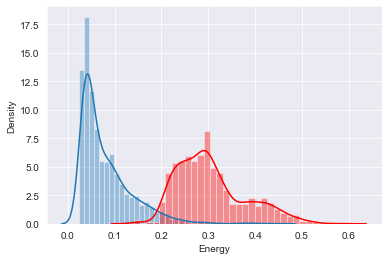

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


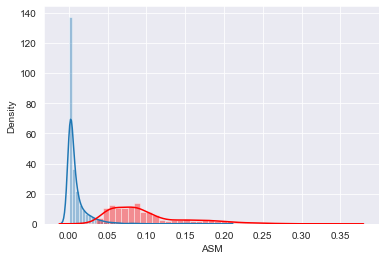

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


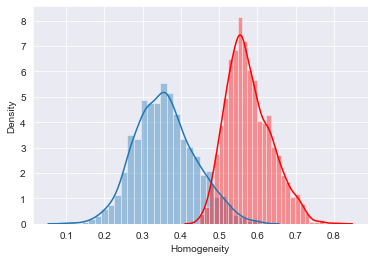

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


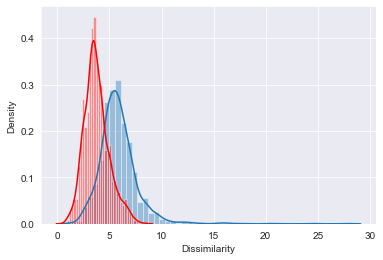

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


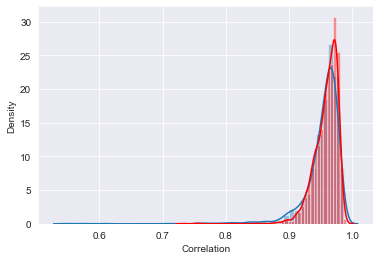

/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/davidg/opt/anaconda3/envs/myenv/lib/pyth

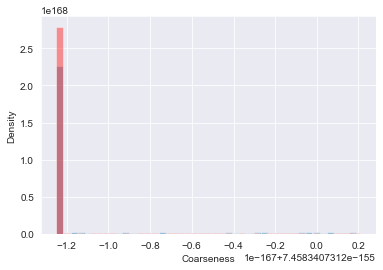

In [18]:
# Descomentar las dos lineas siguientes si es la primera vez que se corre el código 
# de lo contrario mantener comentadas 
columns.remove('Image')
columns.remove('Class')

#Definición de clases.
san = dfmr[dfmr['Class']==1]
enf = dfmr[dfmr['Class']==0]



for column in columns: 
    sns.distplot(san[column])
    sns.distplot(enf[column],color='red')
    plt.show()

### Balanceo de la información

Debido al desbalance que puede exitir en algunas bases de datos respecto a la información que se tiene se relizan protocolos para balancear la información para esto, se realiza primero un análisis de frecuencias 

Total sanos: 1683 % 0.4473684210526316
Total enfermos: 2079 % 0.5526315789473685
Total de pacientes: 3762
/Users/davidg/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


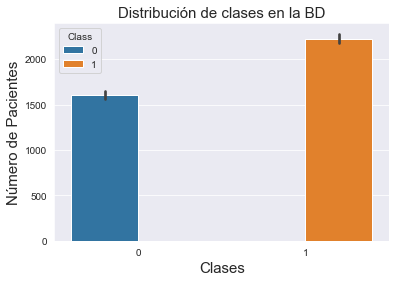

In [19]:
# Utilizaremos las bibliotecas que ya se encuntran cargadas para manipulación y visualización.
# En este caso todas las imagenes cuentan con información balanceada sin embargo podemos hacer un análisis 
# respecto a la frecuencia de sanos y enfermos.

Tsan =  san['Class'].count()
Tenf =  enf['Class'].count()
print('Total sanos:',Tsan,'%',Tsan/(Tsan+Tenf))
print('Total enfermos:',Tenf,'%',Tenf/(Tsan+Tenf))
print('Total de pacientes:',Tsan+Tenf)

# Plot up the distribution of counts
sns.barplot(dfmr['Class'].values,dfmr.index, hue=dfmr['Class'])
plt.title('Distribución de clases en la BD', fontsize=15)
plt.ylabel('Número de Pacientes', fontsize=15)
plt.xlabel('Clases', fontsize=15)
plt.show()
# Notamos que las poblaciones están balanceadas sin embargo eso no sucede en la mayoría de las bases de datos.

### Weighted Loss Equation
Calculate the loss for the zero-th label (column at index 0)

- The loss is made up of two terms.  To make it easier to read the code, you will calculate each of these terms separately.  We are giving each of these two terms a name for explanatory purposes, but these are not officially called $loss_{pos}$ or $loss_{neg}$

    - $loss_{pos}$: we'll use this to refer to the loss where the actual label is positive (the positive examples).
    - $loss_{neg}$: we'll use this to refer to the loss where the actual label is negative (the negative examples).  

$$ loss^{(i)} = loss_{pos}^{(i)} + loss_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

As before, calculate the two terms that make up the loss function.  Notice that you are working with more than one class (represented by columns).  In this case, there are two classes.

Start by calculating the loss for class `0`.

$$ loss^{(i)} = loss_{pos}^{(i)} + loss_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

In [20]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [21]:
train_generator=get_train_generator(dfmr,img_dir,'Image',['Class'])

getting train generator...
Found 3762 validated image filenames.


In [22]:
train_generator.labels

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

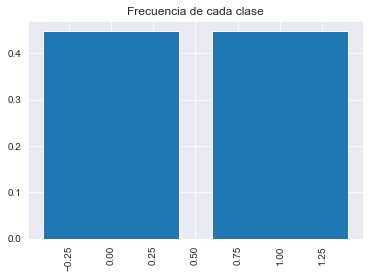

In [23]:
plt.xticks(rotation=90)
plt.bar(x=[0,1], height=np.mean(train_generator.labels, axis=0))
plt.title("Frecuencia de cada clase")
plt.show()

[1683, 2079]
[0.44736842 0.55263158]
Pesos positivos: [0.44736842 0.55263158]
Pesos negativos: [0.55263158 0.44736842]


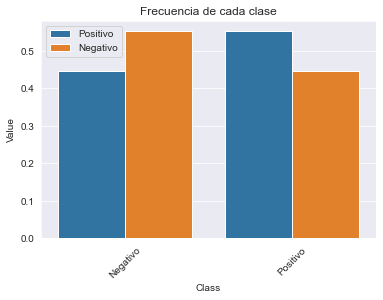

In [24]:
# Calcular las perdidas de entropía para la clase 0 y 1

# Sumamos las poblaciones de clases de una forma distinta a la anterior 

clases = [np.sum(dfmr['Class']==1),np.sum(dfmr['Class']==0)]
print(clases)
print(clases/dfmr['Class'].count())
# Pesos positivos
wp = clases/(dfmr['Class'].count())
print('Pesos positivos:',wp)
clases.reverse()
# Pesos negativos
wn = clases/(dfmr['Class'].count())
print('Pesos negativos:',wn)


labels=['Negativo','Positivo']
data = pd.DataFrame({"Class": labels, "Label": "Positivo", "Value": wp})
data = data.append([{"Class": labels[l], "Label": "Negativo", "Value": v} for l,v in enumerate(wn)], ignore_index=True)

f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)
plt.title("Frecuencia de cada clase")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Creando un modelo donde suponemos que las predicciones son las mismas
y_pred = np.ones([dfmr['Class'].count(),2])
y_pred[:,0] = wp[0] * y_pred[:,0]
y_pred[:,1] = wp[1] * y_pred[:,1]
y_pred[:,0]


# calculate the loss from the positive predictions, for class 0
loss_0_pos = -1 * np.sum(wp[0] *wp[1]* np.log(y_pred[:, 0]))
print(f"loss_0_pos: {loss_0_pos:.4f}")

# Calculate the loss from the negative predictions, for class 0
loss_0_neg = -1 * np.sum(wn[0]*(1 - wp[1]) * np.log(1 - y_pred[:, 0]))
print(f"loss_0_neg: {loss_0_neg:.4f}")

loss_0 = loss_0_neg + loss_0_pos
print(f"loss_0: {loss_0:.4f}")

# calculate the loss from the positive predictions, for class 1
loss_1_pos = -1 * np.sum(wp[1] *wp[1]* np.log(y_pred[:, 1]))
print(f"loss_1_pos: {loss_1_pos:.4f}")

# Calculate the loss from the negative predictions, for class 1
loss_1_neg = -1 * np.sum( wn[1]*(1 - wp[1])* np.log(1 - y_pred[:, 1]))
print(f"loss_1_neg: {loss_1_neg:.4f}")

loss_1 = loss_1_neg + loss_1_pos
print(f"loss_1: {loss_1:.4f}")

loss_0_pos: 748.1302
loss_0_neg: 551.5961
loss_0: 1299.7263
loss_1_pos: 681.3834
loss_1_neg: 605.6292
loss_1: 1287.0126


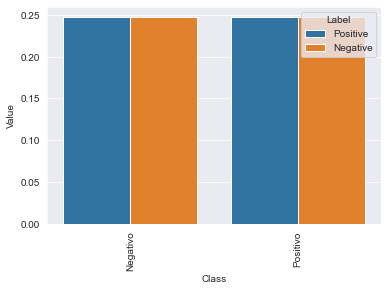

In [26]:
# Ajuste de pesos
pos_weights = wn
neg_weights = wp
pos_contribution = wp * pos_weights 
neg_contribution = wn * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [27]:
# Implementando de manera general los valores de pesos positivos y negativos 
# para finalmente implementar una función de perdida de pesos

def check_for_leakage(df1, df2,col):
    """
    Si existen valores compartidos en ambos sets de datos regresara un valor lógico True
    """

    df1_patients_unique = set(df1[col].values)
    df2_patients_unique = set(df2[col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) # boolean (true if there is at least 1 patient in both groups)
    
    if leakage > 0:
        leakage = True
    else:
        leakage = False
    
    return leakage

### Set de Entrenamiento Validación y Prueba

In [28]:
x,y = dfmr.Class,dfmr.Image

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

In [30]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [31]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=['Class'], 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [32]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            #loss += -1*(K.mean(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon)+ neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) +neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
            #complete this line
        return loss
    
    return weighted_loss

In [33]:
get_weighted_loss(pos_weights,neg_weights)

<function __main__.get_weighted_loss.<locals>.weighted_loss(y_true, y_pred)>

### Generación de cada set

In [34]:
train_df = pd.DataFrame({'Image':y_train,'Class':x_train})
test_df = pd.DataFrame({'Image':y_test,'Class':x_test})
test_df

,Image,Class
1497,Image1498.jpg,1
993,Image994.jpg,0
1859,Image1860.jpg,1
2939,Image2940.jpg,1
615,Image616.jpg,0
...,...,...
2433,Image2434.jpg,0
315,Image316.jpg,1
935,Image936.jpg,0
1259,Image1260.jpg,1


In [35]:
IMAGE_DIR = img_dir
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image",['Class'])

getting train generator...
Found 3009 validated image filenames.


In [36]:
print(len(train_df))
test_df2 = test_df[0:200]
valid_df = test_df[200:]
print(len(test_df))
print(len(valid_df))


3009
753
553


In [37]:
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df2, train_df, IMAGE_DIR, "Image",['Class'])

getting train and valid generators...
Found 3009 validated image filenames.
Found 553 validated image filenames.
Found 200 validated image filenames.


In [38]:
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [39]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [40]:
# create the base pre-trained model
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss([pos_weights[0]], [neg_weights[0]]))

Epoch 1/50
100/100 [==============================] - 6547s 65s/step - loss: 0.2419 - val_loss: 2.8512
Epoch 2/50
100/100 [==============================] - 4372s 44s/step - loss: 0.1688 - val_loss: 2.6031
Epoch 3/50
100/100 [==============================] - 4246s 42s/step - loss: 0.1514 - val_loss: 3.6054
Epoch 4/50
100/100 [==============================] - 4042s 40s/step - loss: 0.1541 - val_loss: 0.2346
Epoch 5/50
100/100 [==============================] - 4051s 41s/step - loss: 0.1327 - val_loss: 0.2230
Epoch 6/50
100/100 [==============================] - 4059s 41s/step - loss: 0.1180 - val_loss: 0.0170
Epoch 7/50
100/100 [==============================] - 4037s 40s/step - loss: 0.1370 - val_loss: 3.4916e-06
Epoch 8/50
100/100 [==============================] - 4050s 41s/step - loss: 0.1271 - val_loss: 2.0186
Epoch 9/50
100/100 [==============================] - 4057s 41s/step - loss: 0.1306 - val_loss: 0.0130
Epoch 10/50
100/100 [==============================] - 4096s 41s/step

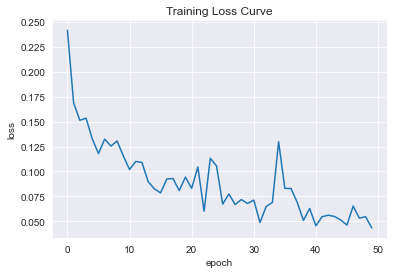

In [41]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=50, 
                              epochs = 50)


plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [44]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [46]:

sys.path.append('/Users/davidg/opt/anaconda3/envs/ComputerVision/lib/python3.7/site-packages')


In [47]:
import sys
import util

In [48]:
import cv2

Error in generating ROC curve for Positivo. Dataset lacks enough examples.


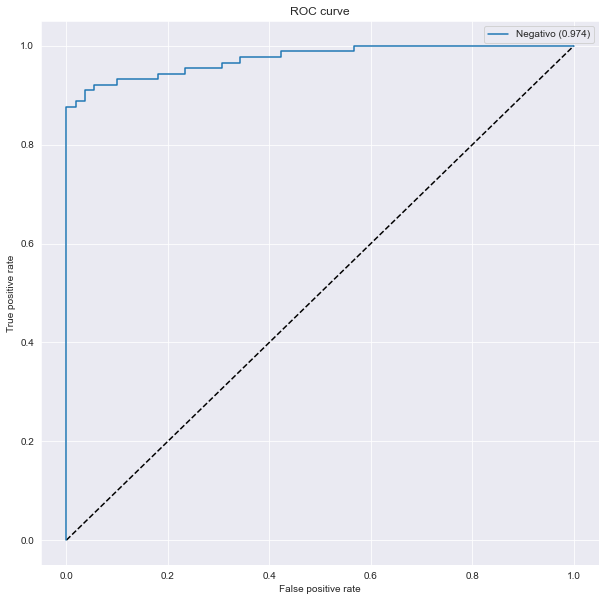

In [49]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

Loading original image
Generating gradcam for class 0


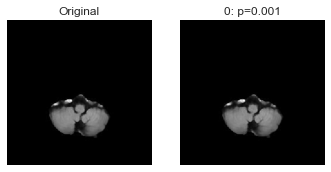

In [51]:
util.compute_gradcam(model, 'Image935.jpg', IMAGE_DIR, dfmr, ['0'],['0'])

Loading original image
Generating gradcam for class 0


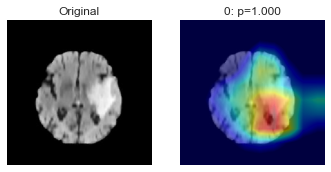

In [52]:
util.compute_gradcam(model, 'Image3.jpg', IMAGE_DIR, dfmr, ['0'],['0'])

Loading original image
Generating gradcam for class 0


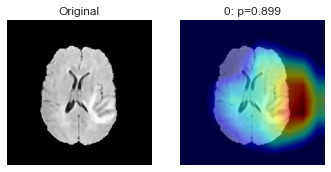

In [55]:
util.compute_gradcam(model, 'Image1260.jpg', IMAGE_DIR, dfmr, ['0'],['0'])

Loading original image
Generating gradcam for class 0


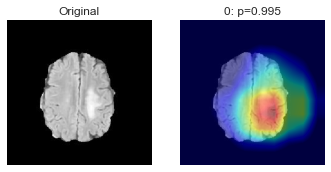

In [56]:
util.compute_gradcam(model, 'Image2643.jpg', IMAGE_DIR, dfmr, ['0'],['0'])

In [54]:
test_df


,Image,Class
1497,Image1498.jpg,1
993,Image994.jpg,0
1859,Image1860.jpg,1
2939,Image2940.jpg,1
615,Image616.jpg,0
...,...,...
2433,Image2434.jpg,0
315,Image316.jpg,1
935,Image936.jpg,0
1259,Image1260.jpg,1


In [57]:
#model.save('neruonal_rmn_bedu.h5')

In [58]:
model.save_weights('pesos_neuronal_rm')